In [ ]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 41.0 MB/s 
     |████████████████████████████████| 596 kB 41.4 MB/s 
     |████████████████████████████████| 61 kB 547 kB/s 
     |████████████████████████████████| 895 kB 38.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import gensim
import gensim.downloader as gensim_api
from sklearn.model_selection import train_test_split

# Import data

In [ ]:
data = pd.read_csv("review_cleaned.csv")

# Data overview

In [ ]:
data.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sum_ufc,funny_label,useful_label,cool_label
0,1YkaVE4vKrUG4U0gaU2gVQ,dSJsIiZ-4tukQlzh6lqoHA,N8dxdQ8rcTggVfo34Mqd3A,5.0,0,0,0,After leaving Rooms 2 Go and left with both st...,2020-05-12 21:18:10,0,0.0,0.0,0.0
1,tRm3Q9gvgbwbko7A3HM66Q,EjeNnnZSQBxAKULRmX3ORA,XlTWGrMdZ8iNt1T0HSiAOQ,3.0,0,0,0,I've been here a few times. In general the foo...,2012-04-03 05:28:46,0,0.0,0.0,0.0
2,dAr-P9mG_ss1EZpYECB1lQ,TdE14X6G42RzVa3NnBYWXQ,jYp3f4Fy_TTLrPseaPWMiQ,4.0,0,0,0,Had the pork belly entree & it was yummy! Don...,2020-02-21 01:48:36,0,0.0,0.0,0.0
3,-wlnDJUuxZmgFVa0ZWmMMA,Sz1xO7IxH7D4FjiHkP9cow,AVx0lohaIerkMzIEUKL6xg,1.0,0,0,0,"I walked into this store, and there were few c...",2017-12-29 20:35:49,0,0.0,0.0,0.0
4,K6GfClzmIeioWILr1-m4Jw,qMifgObSkBD_vnVe65rKdw,jPdGmHBTbZXcIgP8fnVdaw,1.0,0,0,0,"I sat for 15 mins in the lobby, nobody work he...",2019-04-27 14:17:17,0,0.0,0.0,0.0


In [ ]:
data.shape

(83926, 13)

In [ ]:
for col in data:
  print(len(data[col].unique()))

83926
35103
37631
5
230
181
206
83895
83914
446
2
2
2


In [ ]:
main_data = data[["text", "useful", "funny", "cool", "sum_ufc", "useful_label", "funny_label", "cool_label"]]

In [ ]:
## if useful > 10:
##     useful_label =1
## else:
##     useful_label = 0
main_data.tail()

,text,useful,funny,cool,sum_ufc,useful_label,funny_label,cool_label
83921,I've had Copacabana Cuba Café bookmarked for a...,9.0,6.0,11.0,26,0.0,0.0,1.0
83922,What an informative workshop. I live alone but...,10.0,1.0,11.0,22,0.0,0.0,1.0
83923,Stopped here quickly twice during my stay at t...,8.0,1.0,11.0,20,0.0,0.0,1.0
83924,So I really enjoy visiting this location. Spe...,10.0,9.0,13.0,32,0.0,0.0,1.0
83925,My review is specifically for their coffee del...,10.0,2.0,11.0,23,0.0,0.0,1.0


In [ ]:
main_data.shape

(83926, 8)

In [ ]:
len(list(main_data["text"][0]))

504

In [ ]:
## check missing values 
main_data.isna().sum()

text            0
useful          0
funny           0
cool            0
sum_ufc         0
useful_label    0
funny_label     0
cool_label      0
dtype: int64

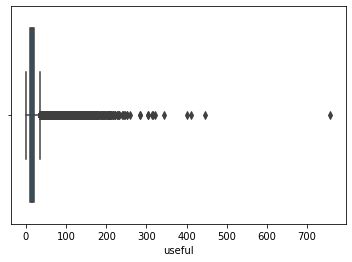

In [ ]:
## check outliers
sns.boxplot(x=main_data['useful'])

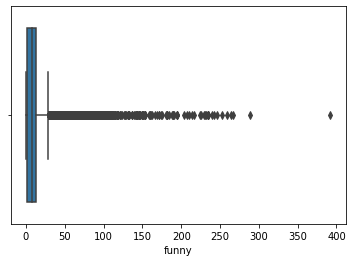

In [ ]:
sns.boxplot(x=main_data['funny'])

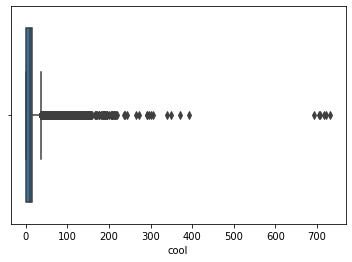

In [ ]:
sns.boxplot(x=main_data['cool'])

In [ ]:
Q1 = main_data.useful.quantile(0.25)
Q3 = main_data.useful.quantile(0.75)
IQR = Q3 - Q1
print("IQR in useful column is ",IQR)
print("Number of outliers in useful column is ", main_data[(main_data.useful < (Q1 - 1.5 * IQR)) |(main_data.useful > (Q3 + 1.5 * IQR))].shape[0])

## make outliers to low or top range
main_data.loc[main_data["useful"] < (Q1 - 1.5 * IQR), "useful"] = (Q1 - 1.5 * IQR)
main_data.loc[main_data["useful"] > (Q3 + 1.5 * IQR), "useful"] = (Q3 + 1.5 * IQR)

IQR in useful column is  10.0
Number of outliers in useful column is  6381


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
Q1 = main_data.funny.quantile(0.25)
Q3 = main_data.funny.quantile(0.75)
IQR = Q3 - Q1
print("IQR in funny column is ",IQR)
print("Number of outliers in funny column is ", main_data[(main_data.funny < (Q1 - 1.5 * IQR)) |(main_data.funny > (Q3 + 1.5 * IQR))].shape[0])

## make outliers to low or top range
main_data.loc[main_data["funny"] < (Q1 - 1.5 * IQR), "funny"] = (Q1 - 1.5 * IQR)
main_data.loc[main_data["funny"] > (Q3 + 1.5 * IQR), "funny"] = (Q3 + 1.5 * IQR)

IQR in funny column is  11.0
Number of outliers in funny column is  3842


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
Q1 = main_data.cool.quantile(0.25)
Q3 = main_data.cool.quantile(0.75)
IQR = Q3 - Q1
print("IQR in cool column is ",IQR)
print("Number of outliers in cool column is ", main_data[(main_data.cool < (Q1 - 1.5 * IQR)) |(main_data.cool > (Q3 + 1.5 * IQR))].shape[0])

## make outliers to low or top range
main_data.loc[main_data["cool"] < (Q1 - 1.5 * IQR), "cool"] = (Q1 - 1.5 * IQR)
main_data.loc[main_data["cool"] > (Q3 + 1.5 * IQR), "cool"] = (Q3 + 1.5 * IQR)

IQR in cool column is  14.0
Number of outliers in cool column is  4199


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


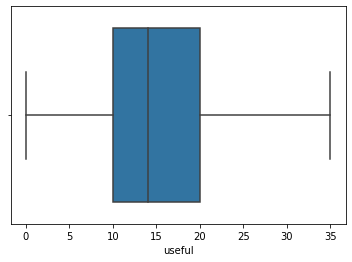

In [ ]:
## check outliers after cleaning
sns.boxplot(x=main_data['useful'])

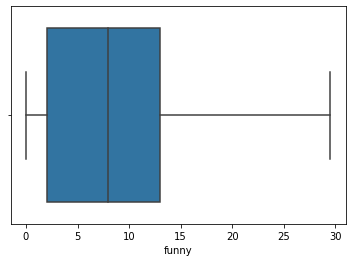

In [ ]:
## check outliers after cleaning
sns.boxplot(x=main_data['funny'])

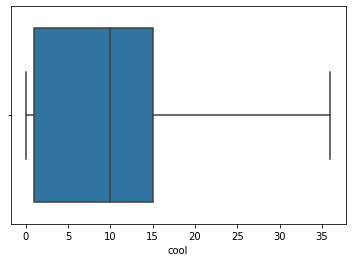

In [ ]:
## check outliers after cleaning
sns.boxplot(x=main_data['cool'])

# EDA

Text(0.5, 1.0, 'Review Distribution Based on useful or not')

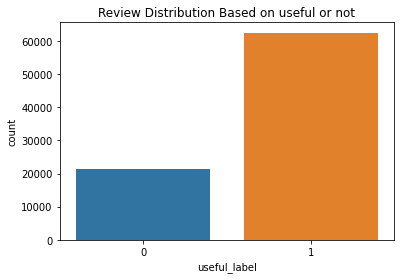

In [ ]:
sns.countplot(
    x = "useful_label",
    data = main_data,
    order = [0,1]
)
plt.xlabel("useful_label")
plt.ylabel("count")
plt.title("Review Distribution Based on useful or not")

Text(0.5, 1.0, 'Review Distribution Based on funny or not')

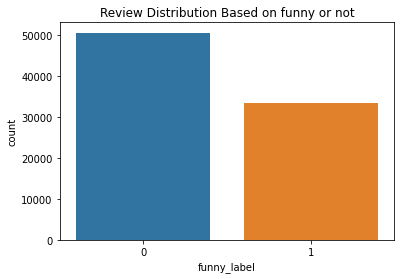

In [ ]:
sns.countplot(
    x = "funny_label",
    data = main_data,
    order = [0,1]
)
plt.xlabel("funny_label")
plt.ylabel("count")
plt.title("Review Distribution Based on funny or not")

Text(0.5, 1.0, 'Review Distribution Based on cool or not')

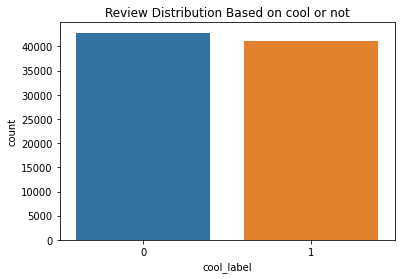

In [ ]:
sns.countplot(
    x = "cool_label",
    data = main_data,
    order = [0,1]
)
plt.xlabel("cool_label")
plt.ylabel("count")
plt.title("Review Distribution Based on cool or not")

## check count distribution for each kind of reviews

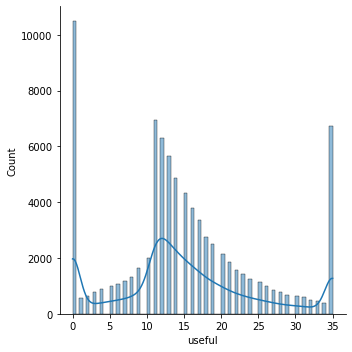

In [ ]:
sns.displot(main_data, x="useful", kde = True)

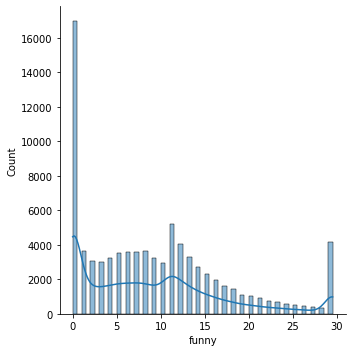

In [ ]:
sns.displot(main_data, x="funny", kde = True)

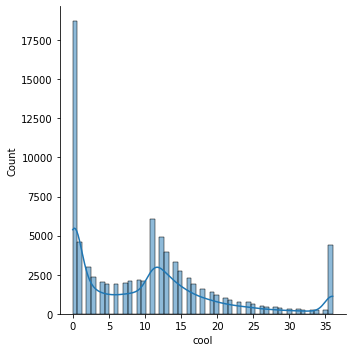

In [ ]:
sns.displot(main_data, x="cool", kde = True)

# Data preprocessing. 

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = WordNetLemmatizer()
def clean_text(texts):
  cleaned_text = texts.copy()
  for index, text in enumerate(texts):
    text = re.sub(r'@[\w]*','',text)
    text = re.sub(r'http[^ ]*','',text)
    text = re.sub(r'pic.[^ ]*','',text)
    text = re.sub(r'[^A-Za-z#]',' ',text)
    
    #lowercase
    text = text.lower()
    #tokenization
    text = nltk.word_tokenize(text)
    #remove stopwords
    text = [word for word in text if word not in stopwords]
    # lemmatizing
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    cleaned_text[index] = text
  return cleaned_text
main_data["text"] = clean_text(main_data["text"])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Data split

In [ ]:
# randomly select 80% data as training set, 20% as testing data
training_set ,testing_set = train_test_split(main_data,test_size=0.2)

#Tfidf

In [ ]:

tfidf = TfidfVectorizer(max_features = 3000)
training_set_tfidf = tfidf.fit_transform(training_set['text'].values.tolist())
testing_set_tfidf = tfidf.transform(testing_set['text'].values.tolist())

# Word2vec

In [ ]:
embeddings = gensim_api.load("word2vec-google-news-300")


[==================================================] 100.0% 1662.8/1662.8MB downloaded


## training data embedding

In [ ]:
docs_vectors = pd.DataFrame()
stopwords = nltk.corpus.stopwords.words("english")
for doc in training_set["text"]:
  temp = pd.DataFrame()
  for word in doc.split(" "):
    if word not in stopwords:
      try:
        word_vec = embeddings[word]
        temp = temp.append(pd.Series(word_vec), ignore_index = True)
      except:
        pass
  doc_vector = temp.mean()
  docs_vectors = docs_vectors.append(doc_vector, ignore_index = True)
docs_vectors.shape


In [ ]:
pd.isnull(docs_vectors).sum().sum()
docs_vectors = docs_vectors.dropna()
training_set_embedding = docs_vectors

## testing data embedding

In [ ]:
docs_vectors = pd.DataFrame()
stopwords = nltk.corpus.stopwords.words("english")
for doc in testing_set["text"]:
  temp = pd.DataFrame()
  for word in doc.split(" "):
    if word not in stopwords:
      try:
        word_vec = embeddings[word]
        temp = temp.append(pd.Series(word_vec), ignore_index = True)
      except:
        pass
  doc_vector = temp.mean()
  docs_vectors = docs_vectors.append(doc_vector, ignore_index = True)
docs_vectors.shape

In [ ]:
pd.isnull(docs_vectors).sum().sum()
docs_vectors = docs_vectors.dropna()
testing_set_embedding = docs_vectors

In [ ]:
np.save('main_data.npy', main_data)
np.save('training_set.npy', training_set)
np.save('testing_set.npy', testing_set)
np.save('training_set_tfidf.npy', training_set_tfidf)
np.save('testing_set_tfidf.npy', testing_set_tfidf)
np.save('training_set_embedding.npy', training_set_embedding)
np.save('testing_set_embedding.npy', testing_set_embedding)

In [ ]:

## load npy data
## for example, main_data = np.load("main_data.npy", allow_pickle= True)
## Especiall, column names of main_data is ["text", "useful", "funny", "cool", "sum_ufc", "useful_label", "funny_label", "cool_label"]